# Load & Preprocess

In [ ]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder

fn = os.path.expanduser('~/Data/CICAPT-IIoT/CICAPT-IIoT Dataset/Network_Traffic/Phase2/phase2_NetworkData.csv')
# nrows = 1000000
df = pd.read_csv(fn) #, nrows=nrows)
df = df.dropna(subset=["Source IP","Destination IP","Source Port","Destination Port","label"])

# format nodes
df["src"] = df["Source IP"].astype(str) + ":" + df["Source Port"].astype(str)
df["dst"] = df["Destination IP"].astype(str) + ":" + df["Destination Port"].astype(str)

# canonicalize labels (0=benign,1=malicious)
df["label_bin"] = LabelEncoder().fit_transform(df["label"])


In [9]:
# Count malicious vs benign flows
print(df["label"].value_counts())

# If you’ve already binarized:
print(df["label_bin"].value_counts())


0    10000
Name: label, dtype: int64
0    10000
Name: label_bin, dtype: int64


# Build the Graph

In [3]:
import networkx as nx

G = nx.DiGraph()
for _, r in df.iterrows():
    G.add_node(r["src"])
    G.add_node(r["dst"])
    # edge carries the flow label and any features you like:
    G.add_edge(r["src"], r["dst"],
               label=int(r["label_bin"]),
               duration=float(r["flow_duration"]),
               bytes=float(r["Tot size"]))


# Create PyG Data for GraphSAGE

In [4]:
import torch
from torch_geometric.utils import from_networkx

# node‐features: here just normalized out‐degree, but you can add more
for n in G:
    G.nodes[n]["x"] = [ G.out_degree(n) / 10.0 ]

# node‐labels: mark any IP:Port that ever participated in a malicious flow
for u,v,d in G.edges(data=True):
    if d["label"] == 1:
        G.nodes[u]["y"] = 1
        G.nodes[v]["y"] = 1
for n in G.nodes():
    G.nodes[n].setdefault("y", 0)

data = from_networkx(G)
data.x = torch.tensor([f["x"] for _,f in G.nodes(data=True)], dtype=torch.float)
data.y = torch.tensor([f["y"] for _,f in G.nodes(data=True)], dtype=torch.long)
# PyG will fill data.edge_index automatically from G.edges


# Train GraphSAGE (Inductive)

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

# 1) Define the model
class SAGE(torch.nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = SAGEConv(in_feats, hid_feats)
        self.conv2 = SAGEConv(hid_feats, out_feats)
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

model = SAGE(data.num_node_features, 32, 2)
device = torch.device("cpu")
model, data = model.to(device), data.to(device)

# 2) Define optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
crit      = torch.nn.CrossEntropyLoss()

# 3) Full-batch training loop
model.train()
for epoch in range(30):
    optimizer.zero_grad()
    out   = model(data.x, data.edge_index)      # forward over all nodes
    loss  = crit(out, data.y)                   # compare to all node labels
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1:02d}  loss = {loss.item():.4f}")


Epoch 01  loss = 0.6001
Epoch 02  loss = 0.5068
Epoch 03  loss = 0.4322
Epoch 04  loss = 0.3728
Epoch 05  loss = 0.3251
Epoch 06  loss = 0.2862
Epoch 07  loss = 0.2541
Epoch 08  loss = 0.2270
Epoch 09  loss = 0.2040
Epoch 10  loss = 0.1842
Epoch 11  loss = 0.1670
Epoch 12  loss = 0.1520
Epoch 13  loss = 0.1387
Epoch 14  loss = 0.1270
Epoch 15  loss = 0.1166
Epoch 16  loss = 0.1073
Epoch 17  loss = 0.0990
Epoch 18  loss = 0.0915
Epoch 19  loss = 0.0848
Epoch 20  loss = 0.0788
Epoch 21  loss = 0.0734
Epoch 22  loss = 0.0684
Epoch 23  loss = 0.0639
Epoch 24  loss = 0.0599
Epoch 25  loss = 0.0562
Epoch 26  loss = 0.0528
Epoch 27  loss = 0.0497
Epoch 28  loss = 0.0469
Epoch 29  loss = 0.0443
Epoch 30  loss = 0.0419


# Embed & Visualize

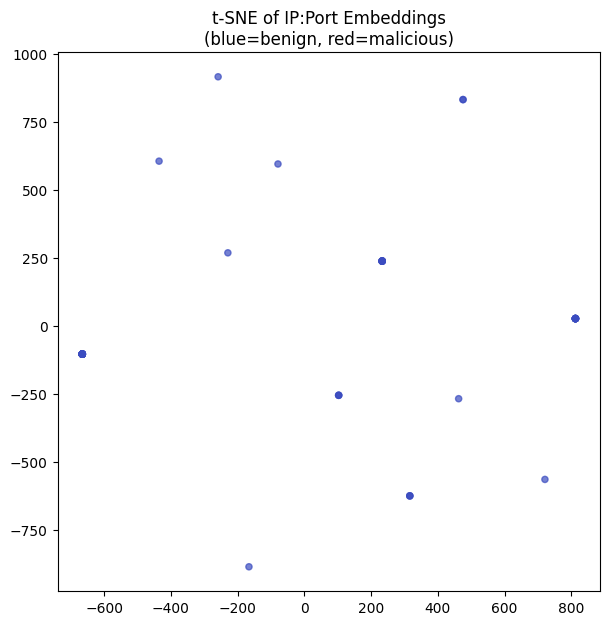

In [7]:
model.eval()
with torch.no_grad():
    Z = model(data.x, data.edge_index).cpu().numpy()

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

z2d = TSNE(n_components=2, perplexity=30).fit_transform(Z)
plt.figure(figsize=(7,7))
plt.scatter(z2d[:,0], z2d[:,1],
            c=data.y.cpu(), cmap="coolwarm", s=20, alpha=0.7)
plt.title("t-SNE of IP:Port Embeddings\n(blue=benign, red=malicious)")
plt.show()


# Red-Teaming Perturbation

In [8]:
# Pick a malicious node:

mal_idx = (data.y==1).nonzero()[0].item()

IndexError: index 0 is out of bounds for dimension 0 with size 0

In [ ]:
# Modify its feature or edges:
# e.g. downscale its out-degree feature
original = data.x[mal_idx].clone()
data.x[mal_idx] *= 0.5


In [ ]:
# Re-embed & Re-visualize:

Zp = model(data.x, data.edge_index).cpu().numpy()
z2dp = TSNE(n_components=2, perplexity=30).fit_transform(Zp)
plt.scatter(z2dp[:,0], z2dp[:,1], c=data.y, s=20, alpha=0.5)
plt.scatter(z2dp[mal_idx,0], z2dp[mal_idx,1], c='k', s=80, label="perturbed")
plt.legend(); plt.show()

In [ ]:
# Observe how that node’s embedding moves closer to benign clusters.